In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
import scipy

In [2]:
# set random seed for debugging purpose, need to turn off when perform monte carlo
# np.random.seed(42)

In [3]:
# plots
def gain(w):
    """Return the power as a function of azimuthal angle, phi."""
    phi = np.linspace(0, 2*np.pi, 1000)
    psi = 2*np.pi * 1 / 2 * np.cos(phi)
    j = np.arange(len(w))
    A = np.sum(w[j] * np.exp(j * 1j * psi[:, None]), axis=1)
    g = np.abs(A)**2
    return phi, g

def get_directive_gain(g, minDdBi=-20):
    """Return the "directive gain" of the antenna array producing gain g."""
    DdBi = 10 * np.log10(g / np.max(g))
    return np.clip(DdBi, minDdBi, None)

## channel generation

In [4]:
def rand_angles(M):
    return np.random.randint(0, 180, M)/180*np.pi # 0->180deg

def rand_distances(M):
    return np.random.randint(1000, 2500, M) # 50-250m

def generate_channels_LOS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    r = np.arange(N)
    h_array_LOS = [np.exp(-2j*np.pi*distances[i]/lambda_)*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]
    h_array_LOS_norm_QoS = []
    h_array_LOS_norm_MaxMin = []
    
    for i in range(M):
        # normalization QoS
        h_i_norm_QoS = h_array_LOS[i]/np.sqrt(rho_min_qos_sigma2)
        h_array_LOS_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_array_LOS[i]/sigma_i
        h_array_LOS_norm_MaxMin.append(h_i_norm_MaxMin)
    
    # generate H_i matrix
    H_array_LOS = []
    H_array_LOS_norm_QoS = []
    H_array_LOS_norm_MaxMin = []
    for i in range(M):
        H_array_LOS.append(np.matmul(h_array_LOS[i], np.conjugate(h_array_LOS[i]).T))
        H_array_LOS_norm_QoS.append(np.matmul(h_array_LOS_norm_QoS[i], np.conjugate(h_array_LOS_norm_QoS[i]).T))
        H_array_LOS_norm_MaxMin.append(np.matmul(h_array_LOS_norm_MaxMin[i], np.conjugate(h_array_LOS_norm_MaxMin[i]).T))
        
    return h_array_LOS, h_array_LOS_norm_QoS, h_array_LOS_norm_MaxMin, H_array_LOS, H_array_LOS_norm_QoS, H_array_LOS_norm_MaxMin
        
def generate_channels(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        # h_i = np.exp(-2j*np.pi*distances[i]/lambda_)*(np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)))
        h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
        # h_i = (np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain and no scale var
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin

def generate_channels_comparison_MaxMin_QoS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        # h_i = np.exp(-2j*np.pi*distances[i]/lambda_)*(np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)))
        # h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
        # h_i = (np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain and no scale var
        h_i = (16*np.random.randn(N)+4 + 1j*(16*np.random.randn(N)+4)).reshape((N, 1)) # follows exp from paper h = randn(4,16) + j*randn(4,16)
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin
    
def generate_channels_secrecy(angle_Eve, angle_Bob, distance_Eve, distance_Bob, sigma_Eve, sigma_Bob, lambda_carrier, N, los=True):
    # generate LoS channel
    r = np.arange(N)
    if los:
        h_Eve = np.exp(-2j*np.pi*distance_Eve/lambda_carrier)*np.exp(-1j*2*(np.pi*r/2)*np.cos(angle_Eve)).reshape((N, 1))
        h_Eve = h_Eve/sigma_Eve
        H_Eve = np.matmul(h_Eve, np.conjugate(h_Eve).T)
        
        h_Bob = np.exp(-2j*np.pi*distance_Bob/lambda_carrier)*np.exp(-1j*2*(np.pi*r/2)*np.cos(angle_Bob)).reshape((N, 1))
        h_Bob = h_Bob/sigma_Bob
        H_Bob = np.matmul(h_Bob, np.conjugate(h_Bob).T)
        
        return h_Eve, h_Bob, H_Eve, H_Bob
    
    # generate rayleigh channel
    h_Eve = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
    h_Eve = h_Eve/sigma_Eve
    H_Eve = np.matmul(h_Eve, np.conjugate(h_Eve).T)

    h_Bob = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
    h_Bob = h_Bob/sigma_Bob
    H_Bob = np.matmul(h_Bob, np.conjugate(h_Bob).T)
    return h_Eve, h_Bob, H_Eve, H_Bob

## Randomization

In [5]:
def recover_w_SVD(W_opt):
    v, d = np.linalg.eig(W_opt)
    w_opt = d[:,0]
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randA(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randB(W_opt):
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    w_opt = np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    
def recover_w_randC(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e = np.sqrt(2)/2*(np.random.randn(W_opt.shape[0]) + 1j*np.random.randn(W_opt.shape[0])).reshape((N, 1))
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))


## Check violation

In [6]:
def check_violation(w, h):
    scale_factor = 1
    constraint = np.abs(np.dot(np.conjugate(h).T, w))[0][0]**2
    # print(constraint)
    violate = constraint < 1
    if violate:
        return np.sqrt(1.0/constraint), constraint
    return scale_factor, constraint

def get_min_scale_factor(w, h_array):
    s = np.min(np.abs(np.matmul(np.conjugate(w).T, h_array)).ravel())
    if s < 1:
        return 1/s
    return 1

def calc_norm2(w):
    # return np.sqrt(np.abs(np.dot(np.conjugate(w).T, w))[0][0])
    return np.linalg.norm(w)

def get_min_snr(w, h_array):
    min_snr = np.inf
    for h in h_array:
        snr = np.abs(np.dot(np.conjugate(h).T, w))**2
        # print(snr)
        min_snr = np.min([min_snr, snr])
    return min_snr

In [7]:
N = 8 # number of transmit antennas
M = 2 # number of mobile users
# P = 1 # transmit power

lambda_carrier = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

P = 1

In [8]:
# angles = rand_angles(M)
# distances = rand_distances(M)

In [9]:
angle_Eve = 0.52359878
angle_Bob = 3.07177948

distance_Eve = 2057
distance_Bob = 1202

sigma_Eve = 1
sigma_Bob = 1

d_Bob_Eve_init = np.sqrt(distance_Eve**2 + distance_Bob**2 -2*distance_Eve*distance_Bob*np.cos(angle_Bob-angle_Eve))
a_Bob_Eve_init = np.arccos(-(distance_Eve**2 - distance_Bob**2 - d_Bob_Eve_init**2)/(2*distance_Bob*d_Bob_Eve_init))

In [120]:
# Eve moves closer to Bob by 100m
d_Bob_Eve_new = d_Bob_Eve_init-1000
distance_Eve_new = np.sqrt(d_Bob_Eve_new**2 + distance_Bob**2 - 2*d_Bob_Eve_new*distance_Bob*np.cos(a_Bob_Eve_init))
angle_Eve_new = angle_Bob - np.arccos(-(d_Bob_Eve_new**2 - distance_Eve_new**2 - distance_Bob**2)/(2*distance_Bob*distance_Eve_new))

In [10]:
angles = [angle_Eve, angle_Bob]
distances = [distance_Eve, distance_Bob]

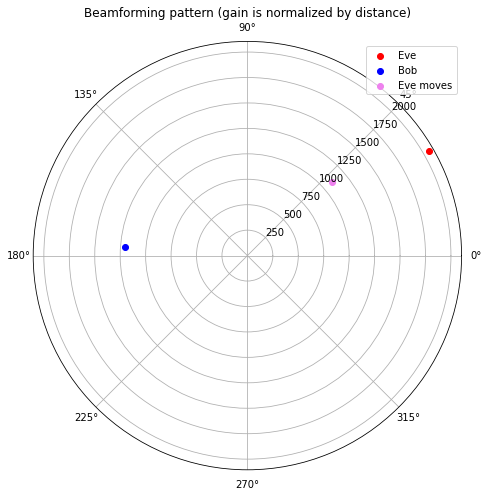

In [125]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
ax.scatter(angle_Eve, distance_Eve, color="red", label="Eve")
ax.scatter(angle_Bob, distance_Bob, color="blue", label="Bob")

ax.scatter(angle_Eve_new, distance_Eve_new, color="violet", label="Eve moves")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized by distance)")
plt.legend()
plt.tight_layout()
plt.show()

## LoS channels

In [43]:
# h_Eve, h_Bob, H_Eve, H_Bob = generate_channels_secrecy(angle_Eve, angle_Bob, distance_Eve, distance_Bob, sigma_Eve, sigma_Bob, lambda_carrier, N, los=True)

In [153]:
distance_list = []
capacity_list = []

for d in tqdm.tqdm(range(100)):
    # Eve moves closer to Bob by 100m
    d_Bob_Eve_new = d_Bob_Eve_init-d*100
    
    if d_Bob_Eve_new < 100:
        break
    
    distance_list.append(d_Bob_Eve_new)
    
    distance_Eve_new = np.sqrt(d_Bob_Eve_new**2 + distance_Bob**2 - 2*d_Bob_Eve_new*distance_Bob*np.cos(a_Bob_Eve_init))
    angle_Eve_new = angle_Bob - np.arccos(-(d_Bob_Eve_new**2 - distance_Eve_new**2 - distance_Bob**2)/(2*distance_Bob*distance_Eve_new))
    
    h_Eve, h_Bob, H_Eve, H_Bob = generate_channels_secrecy(angle_Eve_new, angle_Bob, distance_Eve_new, distance_Bob, sigma_Eve, sigma_Bob, lambda_carrier, N, los=True)
    
    opt_vals = []
    opt_Ws = []
    for s in np.arange(1, 2, 1e-2):
        try:
            W = cp.Variable((N, N), hermitian=True)

            # need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
            constraints = [W >> 0]
            constraints += [cp.real(cp.trace(W)) == P]
            constraints += [1 + cp.real(cp.trace(W @ H_Eve)) == s]

            prob = cp.Problem(cp.Maximize( cp.log(1 + cp.real(cp.trace(W @ H_Bob))) - cp.log(s)),
                         constraints)
            _ = prob.solve(solver="MOSEK", verbose=False)
            opt_vals.append(prob.value)
            opt_Ws.append(W.value)
        except Exception as e:
            print(e)

    W_opt = opt_Ws[np.argmax(opt_vals)]
    opt = np.max(opt_vals)

    w_best = None
    max_capacity = -np.inf
    for i in range(5000):
    # for i in tqdm.tqdm(range(5)):
        # recover randomization
        w_randA = recover_w_randA(W_opt)
        w_randB = recover_w_randB(W_opt)
        w_randC = recover_w_randC(W_opt)

        # scale to norm P
        w_randA /= np.linalg.norm(w_randA)
        w_randB /= np.linalg.norm(w_randB)
        w_randC /= np.linalg.norm(w_randC)

        w_l = [w_randA, w_randB, w_randC]
        capacity = [(np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randA))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randA))**2)).ravel()[0],
                    (np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randB))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randB))**2)).ravel()[0],
                    (np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randC))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randC))**2)).ravel()[0]
                   ]

        w_best_tmp = w_l[np.argmax(capacity)]
        max_capacity_tmp = np.max(capacity)

        if max_capacity_tmp > max_capacity:
            w_best = w_best_tmp
            max_capacity = max_capacity_tmp
    
    capacity_list.append(max_capacity)
    
    # plot figure for gif        
    w = w_best.ravel()
    # Calculate gain and directive gain; plot on a polar chart.
    phi, g = gain(w)
    DdBi = get_directive_gain(g)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='polar', label="meters")
    ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
    # ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
    ax.scatter(angle_Eve_new, distance_Eve_new, color="red", label="Eve")
    ax.scatter(angle_Bob, distance_Bob, color="blue", label="Bob")
    # ax.set_rticks([0, 50, 100, 200, 250])
    ax.set_rlabel_position(45)
    plt.title("Beamforming pattern (gain is normalized)\n distance_Bob_Eve={:.2f}\n best capacity = {:.4f}".format(d_Bob_Eve_new, max_capacity))
    plt.legend()
    ax.legend(loc=(0.8,0.92))
    plt.tight_layout()
    fig.savefig("figures/capacity_gif/fig_Eve_farther_{}.png".format(d))
    plt.close()

 31%|█████████████                             | 31/100 [02:12<04:54,  4.27s/it]


In [154]:
print("max capacity = {:4f}".format(max_capacity))

max capacity = 0.075081


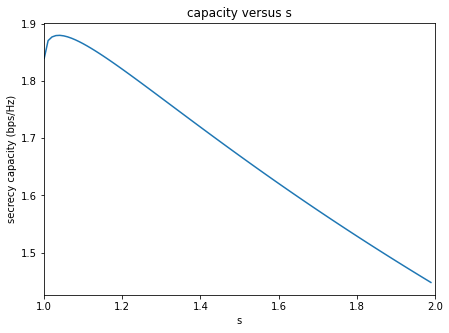

In [152]:
fig = plt.figure(figsize=(7,5))

plt.plot(np.arange(1, 2, 1e-2), opt_vals)
plt.title("capacity versus s")
plt.ylabel("secrecy capacity (bps/Hz)")
plt.xlabel("s")
plt.xlim(1,2)
plt.show()
fig.savefig("figures/capacity_vs_s.png")

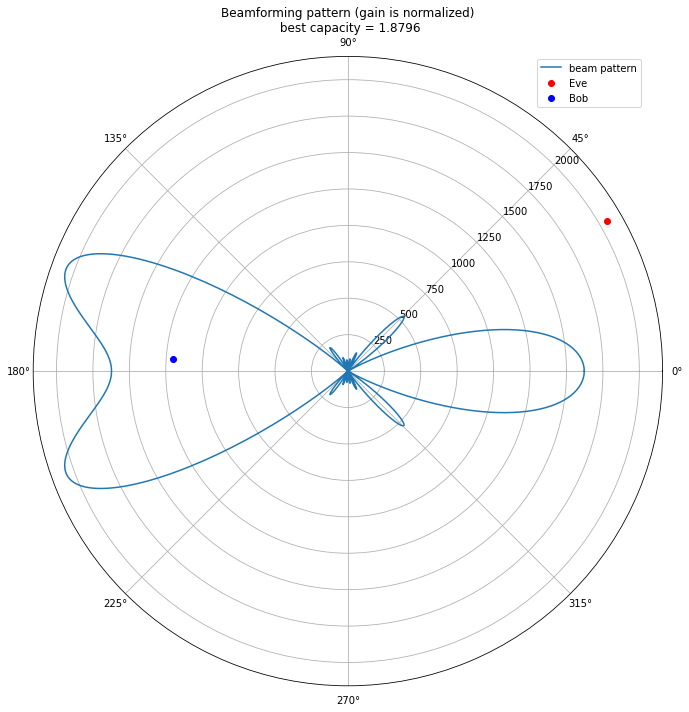

In [85]:
w = w_best.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angle_Eve, distance_Eve, color="red", label="Eve")
ax.scatter(angle_Bob, distance_Bob, color="blue", label="Bob")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized)\n best capacity = {:.4f}".format(max_capacity))
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [ ]:
distance_list_list = []
capacity_list_list = []

for N in tqdm.tqdm([2,4,8,16]):
    distance_list = []
    capacity_list = []

    for d in range(100):
        # Eve moves closer to Bob by 100m
        d_Bob_Eve_new = d_Bob_Eve_init-d*100

        if d_Bob_Eve_new < 100:
            break

        distance_list.append(d_Bob_Eve_new)

        distance_Eve_new = np.sqrt(d_Bob_Eve_new**2 + distance_Bob**2 - 2*d_Bob_Eve_new*distance_Bob*np.cos(a_Bob_Eve_init))
        angle_Eve_new = angle_Bob - np.arccos(-(d_Bob_Eve_new**2 - distance_Eve_new**2 - distance_Bob**2)/(2*distance_Bob*distance_Eve_new))

        h_Eve, h_Bob, H_Eve, H_Bob = generate_channels_secrecy(angle_Eve_new, angle_Bob, distance_Eve_new, distance_Bob, sigma_Eve, sigma_Bob, lambda_carrier, N, los=True)

        opt_vals = []
        opt_Ws = []
        for s in np.arange(1, 2, 1e-2):
            try:
                W = cp.Variable((N, N), hermitian=True)

                # need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
                constraints = [W >> 0]
                constraints += [cp.real(cp.trace(W)) == P]
                constraints += [1 + cp.real(cp.trace(W @ H_Eve)) == s]

                prob = cp.Problem(cp.Maximize( cp.log(1 + cp.real(cp.trace(W @ H_Bob))) - cp.log(s)),
                             constraints)
                _ = prob.solve(solver="MOSEK", verbose=False)
                opt_vals.append(prob.value)
                opt_Ws.append(W.value)
            except Exception as e:
                print(e)

        W_opt = opt_Ws[np.argmax(opt_vals)]
        opt = np.max(opt_vals)

        w_best = None
        max_capacity = -np.inf
        for i in range(1000):
        # for i in tqdm.tqdm(range(5)):
            # recover randomization
            w_randA = recover_w_randA(W_opt)
            w_randB = recover_w_randB(W_opt)
            w_randC = recover_w_randC(W_opt)

            # scale to norm P
            w_randA /= np.linalg.norm(w_randA)
            w_randB /= np.linalg.norm(w_randB)
            w_randC /= np.linalg.norm(w_randC)

            w_l = [w_randA, w_randB, w_randC]
            capacity = [(np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randA))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randA))**2)).ravel()[0],
                        (np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randB))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randB))**2)).ravel()[0],
                        (np.log(1 + np.abs(np.dot(np.conjugate(h_Bob).T, w_randC))**2) - np.log(1 + np.abs(np.dot(np.conjugate(h_Eve).T, w_randC))**2)).ravel()[0]
                       ]

            w_best_tmp = w_l[np.argmax(capacity)]
            max_capacity_tmp = np.max(capacity)

            if max_capacity_tmp > max_capacity:
                w_best = w_best_tmp
                max_capacity = max_capacity_tmp

        capacity_list.append(max_capacity)
    
    distance_list_list.append(distance_list)
    capacity_list_list.append(capacity_list)


 25%|███████████▎                                 | 1/4 [01:13<03:40, 73.63s/it]

In [ ]:
fig = plt.figure(figsize=(7,5))
for i, N in tqdm.tqdm(zip(range(5), [4,8,16,32,64])):
    plt.plot(distance_list_list[i], capacity_list_list[i], marker="x", markersize=5, label="{} antennas".format(N))
plt.title("secrecy capacity versus distance between Bob and Eve")
plt.ylabel("secrecy capacity (bps/Hz)")
plt.xlabel("distance between Bob and Eve (meters)")
# plt.xlim(1,2)
plt.show()
fig.savefig("figures/capacity_vs_d.png")